# Initialisation
Appel de l'ensemble des librairies necessaires. Configuration de l'accelereation materielle GPU avec CUDA

In [1]:
%pip install matplotlib torchinfo numpy pandas torch torchvision tqdm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Importation des déependances requises

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torch.utils.data as data
from torchinfo import summary
from tqdm import tqdm
import os
import csv

Affichage des versions de python et de pytorch ainsi que la disponibilité de l'accélération matérielle GPU avec CUDA.

Ceci est utile uniquement pour vérifier que l'environnement est correctement configuré.

In [3]:
print("Python:", sys.version)
print("Pytorch", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

default_device = "cuda" if torch.cuda.is_available() else "cpu"

Python: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
Pytorch 2.1.1+cu118
CUDA available: True




# Parametres de l'espace
## Modes d'execution

- **Mode local**, Commenter la ligne 1 et decommenter la ligne 2
- **Mode Kaggle**, Commenter la ligne 2 et decommenter la ligne 1

## Training Set

Permet d'utiliser ou non l'ensemble des donnees d'entrainement (utile lorsque qu'il faut effectuer des tests d'implementation rapide)

## BatchSize

Valeur de la batchsize (nombre de donnees dans un lot par iteration)
Une petite valeur de cette batch_size signifie que l'on aura de petits lots. Cela consomme moins de memoire la convergence du modele peut etre longue. Il nous faut donc une batch_size d'une certaine taille.

In [4]:
# base_path = "/kaggle/input/"
base_path = "../"
base_path_data = base_path + "data/"

full_set = True

batch_size = 256

model_name = "axelnet_40_epochs"

In [5]:
# set the seed for reproducibility
torch.manual_seed(42)

# Utility functions

Définition de fonctions utilitaires pour l'affichage des graphiques de résultats, lancer un entrainement et valider le modèle.


## plot_results

Permet d'afficher les résultats d'un entrainement et de validation.

### Arguments

- **hist** : l'histogramme des résultats d'entrainement comprenant `train_loss`, `train_acc`, `val_loss` et `val_acc` pour chaque epoch.

In [6]:
def plot_results(hist):
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.plot(hist["train_acc"], label="Training acc")
    plt.plot(hist["val_acc"], label="Validation acc")
    plt.legend()
    plt.subplot(122)
    plt.plot(hist["train_loss"], label="Training loss")
    plt.plot(hist["val_loss"], label="Validation loss")
    plt.legend()

## train_epoch

Permet de lancer un epoch d'entrainement.

Le réseau est mis en mode entrainement et les gradients sont calculés.

### arguments

- **net**: le modèle à entrainer
- **dataloader**: le data loader à utiliser pour l'entrainement qui contient les images d'entrainement
- **lr**: le learning rate à utiliser, par défaut 0.01
- **optimizer**: l'optimiseur à utiliser, par défaut Adam
- **loss_fn**: la fonction de loss à utiliser, par défaut NLLLoss

### returns

- **loss**: la valeur de loss pour cet epoch
- **accuracy**: la valeur d'accuracy pour cet epoch

In [7]:
def train_epoch(
    net,
    dataloader,
    lr=0.01,
    optimizer=None,
    loss_fn=nn.NLLLoss(),
):
    print("Training:")
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr)
    net.train()
    total_loss, acc, count = 0, 0, 0
    for i, (features, labels) in tqdm(enumerate(dataloader), total=len(dataloader)):
        optimizer.zero_grad()
        lbls = labels.to(default_device, non_blocking=True)
        out = net(features.to(default_device))
        loss = loss_fn(out, lbls)  # cross_entropy(out,labels)
        loss.backward()
        optimizer.step()
        total_loss += loss
        _, predicted = torch.max(out, 1)
        acc += (predicted == lbls).sum()
        count += len(labels)
    return total_loss.item() / count, acc.item() / count

## validate

Permet d'obtenir les résultats du modèle avec les donnnées de validation.

Les gradients ne sont pas calculés.

### arguments

- **net**: le modèle entrainé.
- **dataloader**: le data loader à utiliser pour l'entrainement qui contient les images de validation
- **loss_fn**: la fonction de loss à utiliser, par défaut NLLLoss. Doit être la même que celle utilisée pour l'entrainement pour avoir des résultats pertinents.

### returns

- **loss**: la valeur de loss pour cet epoch
- **accuracy**: la valeur d'accuracy pour cet epoch

In [8]:
def validate(net, dataloader, loss_fn=nn.NLLLoss()):
    print("Validation:")
    net.eval()
    count, acc, loss = 0, 0, 0
    with torch.no_grad():
        for i, (features, labels) in tqdm(enumerate(dataloader), total=len(dataloader)):
            lbls = labels.to(default_device)
            out = net(features.to(default_device))
            loss += loss_fn(out, lbls)
            pred = torch.max(out, 1)[1]
            acc += (pred == lbls).sum()
            count += len(labels)
    return loss.item() / count, acc.item() / count

## train 

permet de lancer l'entrainement du modèle sur un nombre déterminer d'epochs.

### arguments

- **net**: le modèle à entrainer
- **train_loader**: le data loader à utiliser pour l'entrainement qui contient les images d'entrainement
- **val_loader**: le data loader à utiliser pour l'entrainement qui contient les images de validation
- **optimizer**: l'optimiseur à utiliser, par défaut Adam
- **lr**: le learning rate à utiliser, par défaut 0.01
- **epochs**: le nombre d'epochs à effectuer, par défaut 10
- **loss_fn**: la fonction de loss à utiliser, par défaut NLLLoss.

### returns

- **train_loss**: la liste des valeurs de loss pour chaque epoch
- **train_accuracy**: la liste des valeurs d'accuracy pour chaque epoch
- **val_loss**: la liste des valeurs de loss pour chaque epoch
- **val_accuracy**: la liste des valeurs d'accuracy pour chaque epoch

In [9]:
def train(
    net,
    train_loader,
    val_loader,
    optimizer=None,
    lr=0.01,
    epochs=10,
    loss_fn=nn.NLLLoss(),
):
    optimizer = optimizer or torch.optim.Adam(net.parameters(), lr=lr)
    res = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    for ep in range(epochs):
        tl, ta = train_epoch(
            net, train_loader, optimizer=optimizer, lr=lr, loss_fn=loss_fn
        )
        vl, va = validate(net, val_loader, loss_fn=loss_fn)
        print(
            f"Epoch {ep:2}, Train acc={ta:.3f}, Val acc={va:.3f}, Train loss={tl:.3f}, Val loss={vl:.3f}"
        )
        res["train_loss"].append(tl)
        res["train_acc"].append(ta)
        res["val_loss"].append(vl)
        res["val_acc"].append(va)
    return res

Mise en place des transformations à appliquer aux images d'entrée.

1. Transformation en tenseur
2. Redimensionnement des images en 256x256
3. Coupe centrale de 256x256 si l'image est plus grande ou non carré
4. Normalisation des valeurs des pixels entre 0 et 1. Grâce à une moyenne de 0.5 et un écart type de 0.5

In [10]:
transforms = T.Compose(
    [
        T.ToTensor(),
        T.Resize(256, antialias=True),
        T.CenterCrop(256),
        T.Normalize(0.5, 0.5),
    ]
)

Chargement des données d'entrainement fournies via `ImageFolder` en appliquant les transformations.

In [11]:
train_dataset_all = ImageFolder(root=base_path_data + "/train", transform=transforms)

Le nombre d'images par classes n'est pas équilibré, il y a donc un poids à appliquer à chaque classe pour que le modèle ne soit pas biaisé.

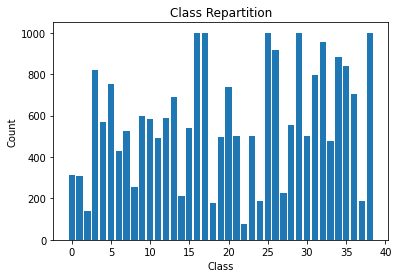

In [12]:
from collections import Counter

class_counts = Counter(train_dataset_all.targets)

plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Repartition")
plt.show()

# Création des poids de répartition des classes

Comme la répartition des classes n'est pas équilibrée, il faut créer des poids pour chaque classe afin de compenser ce déséquilibre pour la loss_function.

Une autre solution aurait été de créer des images supplémentaires pour les classes sous représentées. Ce procédé de DataAugmentation repose souvent sur de la translation spatiale des images (les retourner, inverser la symmetrie, etc...). Pour certains cas, on peut également jouer sur les canaux de colorimétrie (négatif par exemple).

Par soucis de simplicité, nous avons choisi de créer des poids.

In [13]:
max_class_count = max(class_counts.values())
total_samples = sum(class_counts.values())
class_weights = [class_counts[label] / max_class_count for label in class_counts.keys()]


Découpe des données d'entrainement en données d'entrainement et données de validation avec un ratio de 80/20.

La découpe est faites aléatoirement avec un seed fixé pour avoir toujours les mêmes résultats.

In [14]:

# split the dataset in train and val set
train_size = int(0.8 * len(train_dataset_all))
val_size = len(train_dataset_all) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset_all, [train_size, val_size]
)

Création des data loaders pour l'entrainement et la validation sur base du paramètre `full_set` qui permet de choisir si l'on utilise l'ensemble des données d'entrainement ou seulement une partie.

Ceci n'est utile que pour effectuer des tests d'implémentation rapide.

In [15]:
if full_set == True:
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
    )
else:
    # get the indices of 1000 random samples
    indices_train = torch.randperm(len(train_dataset))[:1024]
    indices_val = torch.randperm(len(val_dataset))[:200]
    # create a sampler using the indices
    sampler_train = data.SubsetRandomSampler(indices_train)
    sampler_val = data.SubsetRandomSampler(indices_val)

    # create a dataloader using the sampler
    train_loader = data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=sampler_train
    )
    val_loader = data.DataLoader(
        val_dataset, batch_size=batch_size, sampler=sampler_val
    )

# Création du modèle
## Choix du modèle
Afin de traiter le probleme intial, nous avons fait le choix de partir sur une architecture similaire a AlexNet. Vaincqueur du ILSVRC en 2012, ce classifieur est composé de 8 couches dont 5 de convolution. L'intérêt d'un modèle comme celui-ci est qu'il propose de bons résultats ton en étant rainsonnable sur sa complexité : 
-  La taille des filtres n'est pas trop importante ce qui permet d'effectuer des convolutions rapides
-  La taille des filtres permet également de projeter des caractéristiques plus discriminantes (par rapport à de plus grands filtres)
-  Le nombre de couches est raisonnable ce qui évite l'overfitting et accélère l'entrainement
-  Il peut être couplé avec une fonction de DropOut permettant de "Désactiver" certains neuronne pour éviter l'overfitting

Ainsi, malgré que ce modèle soit assez ancien (de manière relative), ses performances restent très pertinentes avec une complexité contenue

![AlexNetModel](https://miro.medium.com/v2/resize:fit:960/0*d0G7SqdXlK67J5aN.png)
Modèle AxelNet (https://miro.medium.com/v2/resize:fit:960/0*d0G7SqdXlK67J5aN.png)

## Couche de convolution et pooling
Les différentes couches de convolution permettent de former des filtre qui vont saisir des motifs caractéristiques de notre image. On applique des opérations de pooling à sortie des couches de convolution afin de réduire la dimension de l'image et conserver les caractéristiques importantes. L'opération de convolution est une opération de base en traitement du signal (utilisée en filtrage par exemple). Cette opération peut rapidement devenir assez couteuse et il est donc important de bien choisir la taille des couches de convolution : 
- On commence avec une couche de convolution prenant 64 canaux d'entrée et surtout un noyau de convolution important. Plus il est important, moins on va saisir de détails (la convolution s'effectue avec un noyau plus grand donc on forme notre image avec les informations de 25 pixels avec un noyeau de 5)
- Après la couche de pooling, notre image est un vecteur caractérisitque projeté dans un espace plus petit contenant moins de détails. Il nous faut dès lors saisir des détails de manière plus précise, on vient donc diminuer la taille du noyeau de convolution. Ainsi, on prendra l'information de 9 pixels pour la sortie de notre image, on capture donc plus de détails.


Avec une 2e couche, on analyse et détecte des formes plus grandes et ainsi de suite.

De plus, comme on combine les formes basiques obtenues par la première couche, on analyse des formes de plus en plus complexes et grandes.Donc, plus on avance dans les couches de convolution, plus on va vers une sorte de sémantique

## Couche ReLu

La couche ReLu permettant d'introduire de la non-linératié est assez intéressante dans notre contexte. Tout d'abord, elle peu couteuse en calcul de part sa simplicité (f(x)=max(0,x)) par rapport à une Sigmoid par exemple.\

En effet, les fonctions d'activation telles que la sigmoïde peuvent entraîner un problème du gradient qui diminue avec la profondeur du réseau ce qui pose porblème. La fonction ReLU évite ce problème en permettant au gradient de passer à travers pour les valeurs positives.

## Average pooling et LinearConnection
À la sortie de nos couches de convolution et du MaxPooling, nous obtenons une représentations réduite de notre image. Celle-ci est constituée des caractérisitques extraite par les opérations de convolution successive et la réduction de notre espace.
La couche d'average pooling va prendre la moyenne des activations pour chaque canaux et faire retomber la dimension de notre sortie à 256x6x6. On obtient un vecteur caractéristique petit mais très dense en caractéstiques.

Enfin, les couches Linear permettent de passer de notre vecteur 256x6x6 au nombre de classes souhaitées. Il s'agit de simple couches fully connected.

## Reduction spatiale et canaux
Un point intéressant à noter dans le modèle présenté, est la diminution progressive de la dimension spatiale de l'image (sortie d'image en 6x6) et l'augmentation du nombre de canaux (384 au maximum puis se terminant à 256). 
Cette méthode permet de créer de la profondeur (matérialisée par les canaux) et ainsi saisir des motifs complexes robustes à la translation. 

Ainsi, en plus d'accélerer les calculs en réduisant les dimensions des images sur lesquelles nous appliquons des opérations, nous permettons au modèle de mieux se spécialiser (canaux). 


In [16]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.fc1 = nn.Linear(256 * 6 * 6, 2048)
        self.fc2 = nn.Linear(2048, 1024)
        self.fc3 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.maxpool(self.relu(self.conv5(x)))
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Instantiate the network
net = AlexNet(num_classes=39)
net = net.to(default_device)

summary permet d'afficher un résumé du modèle avec le nombre de paramètres et la taille de la sortie de chaque couche.

Cela permet d'avoir une estimation de la puissance de calcul ainsi que de la mémoire nécessaire pour l'entrainement.

In [17]:
summary(net, input_size=(batch_size, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [256, 39]                 --
├─Conv2d: 1-1                            [256, 64, 63, 63]         23,296
├─ReLU: 1-2                              [256, 64, 63, 63]         --
├─MaxPool2d: 1-3                         [256, 64, 31, 31]         --
├─Conv2d: 1-4                            [256, 192, 31, 31]        307,392
├─ReLU: 1-5                              [256, 192, 31, 31]        --
├─MaxPool2d: 1-6                         [256, 192, 15, 15]        --
├─Conv2d: 1-7                            [256, 384, 15, 15]        663,936
├─ReLU: 1-8                              [256, 384, 15, 15]        --
├─Conv2d: 1-9                            [256, 256, 15, 15]        884,992
├─ReLU: 1-10                             [256, 256, 15, 15]        --
├─Conv2d: 1-11                           [256, 256, 15, 15]        590,080
├─ReLU: 1-12                             [256, 256, 15, 15]  

# Lancement de l'entainement

Lancement de l'entrainement du modèle avec les paramètres suivants:

- **epochs**: Nombre d'Epochs
Dans notre cas (petit nombre de données), nous avons choisit de ne pas dépasser 20 sur le nombre d'itérations. En effet, au delà, le modèle over-fit et notre loss_function ne diminue plus.
Ainsi, ce paramètre est à ajuster en fonction de notre jeu de données et de la profondeur de nombre modèle.

- **lr**: Learning Rate
Nous avons ici choisi de mettre un LearningRate assez faible afin de bien laisser le temps au modèle de converger. Nous pourrions mettre en place un LearningRate adaptatif pour que celui-ci augmente en fonction des résulats (augmente lorsque l'erreur est importante) afin d'accelerer la convergence.
À contrario, dans le cas où nous aurions choisit un LR trop petit, nous aurions pu nous bloquer dans un optimum local...

- **loss_fn**: Loss Function
Enfin, la loss function utilisée est ici une fonction minimisant l'entropie entre la probabilité prédite et la bonne valeur (étiquette). Ainsi, plus la différence de valeur est importante entre notre prédiction et l'étiquette plus l'entropie est grande (incertitude). Cette fonction est très utilisée dans le cadre des classifieur d'images. 


In [18]:
hist = train(
    net, train_loader, val_loader, epochs=20, lr=0.0001, loss_fn=nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(default_device))
)
plot_results(hist)

Training:


  0%|          | 0/71 [00:00<?, ?it/s]

100%|██████████| 71/71 [00:40<00:00,  1.75it/s]


Validation:


100%|██████████| 18/18 [00:09<00:00,  1.99it/s]


Epoch  0, Train acc=0.108, Val acc=0.229, Train loss=0.012, Val loss=0.010
Training:


100%|██████████| 71/71 [00:38<00:00,  1.86it/s]


Validation:


100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


Epoch  1, Train acc=0.357, Val acc=0.452, Train loss=0.008, Val loss=0.006
Training:


100%|██████████| 71/71 [00:44<00:00,  1.61it/s]


Validation:


100%|██████████| 18/18 [00:10<00:00,  1.64it/s]


Epoch  2, Train acc=0.523, Val acc=0.575, Train loss=0.006, Val loss=0.005
Training:


100%|██████████| 71/71 [00:46<00:00,  1.53it/s]


Validation:


100%|██████████| 18/18 [00:10<00:00,  1.76it/s]


Epoch  3, Train acc=0.600, Val acc=0.598, Train loss=0.004, Val loss=0.004
Training:


100%|██████████| 71/71 [00:37<00:00,  1.91it/s]


Validation:


100%|██████████| 18/18 [00:10<00:00,  1.67it/s]


Epoch  4, Train acc=0.648, Val acc=0.653, Train loss=0.004, Val loss=0.004
Training:


100%|██████████| 71/71 [00:38<00:00,  1.86it/s]


Validation:


100%|██████████| 18/18 [00:10<00:00,  1.79it/s]


Epoch  5, Train acc=0.693, Val acc=0.691, Train loss=0.003, Val loss=0.003
Training:


 61%|██████    | 43/71 [00:21<00:14,  1.91it/s]

# Sauvegarde des poids

In [ ]:
import datetime

now = datetime.datetime.now()
timestamp = now.strftime("%Y-%m-%d_%H-%M-%S")

filename = base_path + f"/deeplearning_{model_name}_{timestamp}.pt"
torch.save(net.state_dict(), filename)

# Obtention des résultat de test
Utilisation du réseau sur les données de test pour obtenir les résultats.

Les résultats sont ensuite écrit dans un fichier csv.

In [ ]:
train_path = base_path_data + "/train"


label_names = train_dataset_all.find_classes(train_path)[0]

In [ ]:
test_path = base_path_data + "/test"
test_path_files = test_path + "/unknown"

# create a list of all the image paths in the test folder
test_images = [os.path.join(test_path_files, f) for f in os.listdir(test_path_files)]

# create a list of all the image ids
test_ids = [os.path.splitext(os.path.basename(f))[0] for f in test_images]

# create a dataset from the test images
test_dataset = ImageFolder(root=test_path, transform=transforms)

# create a dataloader from the test dataset
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

In [ ]:
# set the model to evaluation mode
net.eval()

# create a list to store the predictions
predictions = []

# loop through the test loader and make predictions
with torch.no_grad():
    for i, (features, labels) in tqdm(enumerate(test_loader), total=len(test_loader)):
        out = net(features.to(default_device))
        _, predicted = torch.max(out, 1)
        predictions += predicted.cpu().tolist()

In [ ]:
predicted_labels = [label_names[prediction] for prediction in predictions]


# create a list of tuples with the test ids and their predicted labels
results = list(zip(test_ids, predicted_labels))

# save the results to a CSV file
with open(
    base_path + f"results_{model_name}_{timestamp}.csv", mode="w", newline=""
) as file:
    writer = csv.writer(file)
    writer.writerow(["Id", "Disease (target)"])
    writer.writerows(results)

# Annexes

## Utilisation du model Axelnet pré-entrainé sur ImageNet.

L'utilisation d'axelnet permet d'obtenir de meilleurs résultats car les poids sont déjà ajustés lors de l'entrainement sur Imagenet. Cela permet de gagner du temps et d'avoir un modèle plus performant en gagnant du temps d'entrainement. 

Cependant, il faut faire attention à la taille et à la normalisation des images. En effet, les images d'entrainement d'axelnet sont de taille 224x224 et normalisées avec une moyenne de 0.485 et un écart type de 0.229. Il faut donc adapter les images d'entrainement pour qu'elles correspondent à ces paramètres.

Le nombre de classes d'AxelNet (1000) diffère du nombre de classes du dataset. Pour y remédier, nous avons 2 solutions:

- La plus simple: est de lancé un entrainement comme avec un model non-entrainé et de le laisser modifier ses poids pour s'adapter à nos classes. Vu qu'il y a moins de classes dans notre datasets, les poids de sorties pour les classe après 39 (nombres de labels ici) vont devenir inutiles et ne seront pas utilisés.
- La plus précise: est de modifier la dernière couche du modèle pour faire correspondre le nombre de noeuds de sortis avec notre ombre de classes et d'ensuite entrainer le modèle sur notre dataset.

ici, nous avons choisi la première solution pour sa simplicité.
Malgré cela, les résultast sont plus que satisfaisants.

In [ ]:
std_normalizel_axel = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

transforms_axel = T.Compose(
    [
        T.Resize(256, antialias=True),
        T.CenterCrop(224),
        T.ToTensor(),
        std_normalize_axel,
    ]
)

net = models.alexnet(weights="DEFAULT")
net.to(default_device)


summary(net, input_size=(batch_size, 3, 224, 224))

In [ ]:
hist = train(
    net,
    train_loader,
    val_loader,
    epochs=10,
    lr=0.0001,
    loss_fn=nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(default_device)),
)
plot_results(hist)